
## **End-to-End Classification**
*Feature Engineering and Model Comparison on High-Cardinality Data*

### **1 - Overview and Goal** 

This notebook demonstrates a careful, data-driven approach to modeling using a classical dataset with high-cardinality categorical features, emphasizing manual feature engineering and thoughtful feature while systematically examines each feature, reduces cardinality where appropriate, merges semantically similar categories, and preserves meaningful signals while minimizing redundancy. It presents an end-to-end workflow, from data preparation to model evaluation

The [Adult Income Census](https://www.kaggle.com/datasets/uciml/adult-census-income) dataset will be used, which contains demographic and employment information collected from individuals across the United States. The goal is to predict whether a person earns more than $50K per year based on these features.

The notebook is organized in a step-by-step style and includes:

- Data Overview and Preparation: Understanding the dataset, handling missing values, and preparing features for modeling.
- Modeling and Evaluation: Training multiple classification models, evaluating their performance, and comparing results to identify the most effective approach.

### **2 - Data Overview, Preparation**

#### **2.1 - Data Loading and Preliminary Analysis and Preparation**

First, the necessary libraries for data manipulation, visualization, preprocessing, and modeling will be imported.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

Next, the dataset will be loaded and briefly explored to understand its structure and key characteristics.

In [9]:
data = pd.read_csv("adult.csv")

In [10]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [11]:
data.shape

(32561, 15)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The dataset contains 32561 samples and 15 features, comprising a mix of categorical and numerical variables. These features represent various demographic, employment, and financial details of each individual in the dataset.

The meaning of each feature is generally as follows[$^1$](https://minds.wisconsin.edu/bitstream/handle/1793/82299/TR1869%20Junda%20Chen%203.pdf?sequence=1&isAllowed=y) and will be explored in more detail later:

- **age**: Age of the individual
- **workclass**: Sector or organizational type of employment
- **fnlwgt**: A statistical weighting value that estimates how much each row represents a subset of the actual population. This column will be excluded from analysis and modeling as it does not provide predictive insight. 
- **education**: Type of education
- **education.num**: Number representing the level of education the individual has received
- **marital.status**: Marital status of the individual
- **occupation**: Specific occupation type
- **relationship**: Type of relationship the individual has (e.g., spouse, husband)
- **race**: Race of the individual
- **sex**: Sex of the individual
- **capital.gain**: Capital gain in dollars
- **capital.loss**: Capital loss in dollars
- **hours.per.week**: Number of hours worked per week
- **native.country**: Native country of the individual
- **income**: Target variable indicating whether the individual earns `<=50K` or `>50K` per year in dollars

In [14]:
data = data.drop(columns=["fnlwgt"])

In [15]:
columns = data.select_dtypes(include="object").columns

In [16]:
for col in columns:
    print(data[col].unique())
    print(data[col].value_counts())

['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Ma

There is a clear class imbalance across many features, notably in the target feature.

The missing values in the dataset are consistently represented by the symbol "?". 

There are no noticeable inconsistencies in category naming. However, the dataset suffers from high cardinality, as most of the features are categorical and contain a large number of unique categories.

To make things clearer and easier to process, the missing values will be replaced with `NaN`.

In [18]:
data = data.replace("?", np.nan)

In [19]:
print(data.isna().sum())
print(f"Total missing values: {data.isna().any(axis=1).sum()}, and it constitutes {((data.isna().any(axis=1).sum())/data.shape[0] * 100):.2f}%")

age                  0
workclass         1836
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64
Total missing values: 2399, and it constitutes 7.37%


In [20]:
(data["workclass"].isna() & data["occupation"].isna()).sum()

1836

In [21]:
nan_row = data.isna().sum(axis=1)

In [22]:
nan_row.value_counts()

0    30162
2     1809
1      563
3       27
Name: count, dtype: int64


The rows that have at least one missing value are 2,399, which constitute about 7% of the data. Most of the samples with missing values have two missing fields. The missingness is not random: 1,836 samples have missing values in both workclass and occupation, suggesting a systematic pattern.

Thus, all rows with missing values will be dropped because:

- The missinginess is not random, and any form of imputation could introduce a systematic bias to the model.
- The missing values are in categorical features.
- Categorical features inherently carry unique information, so imputing them implies certainty, which may shift the decision boundaries of the model.
- Classification models often make hard splits based on categories, and categorical entropy is highly sensitive to errors, so imputation could negatively affect model's integiry.
- The total missingingness is mild, approximatly 7% of data.


In [24]:
data = data.dropna()

In [25]:
data.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


In [26]:
print(data.isna().sum())
print(data.info())

age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education.num   30162 non-null  int64 
 4   marital.status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital.gain    30162 non-null  int64 
 10  capital.loss    30162 non-null  int64 
 11  hours.per.week  30162 non-

#### **2.2 - Design and Methodology**

In [28]:
for col in columns:
    print(data[col].unique())
    print(data[col].value_counts())

['Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay']
workclass
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64
['HS-grad' '7th-8th' 'Some-college' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-voc' '1st-4th' '5th-6th' 'Assoc-acdm'
 '12th' '9th' 'Preschool']
education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: count, dtype: int64
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
marital.status
Married-

In [29]:
print(data[columns].nunique())
print(f"The total number of unique values across all categories is: {data[columns].nunique().sum()}")

workclass          7
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64
The total number of unique values across all categories is: 100



It was mentioned earlier that this dataset has high cardinality, which occurs when features contain many unique categories. Modeling with categorical features can be approached in two ways:
1. Encoding the categories so they can be represented numerically, or
2. Using models that natively support categorical features, both approaches will be tested in this notebook.

From a universal modeling and system engineering perspective, the first approach (encoding) is often preferred, as it produces more consistent, explainable, and portable models.

The main challenge with high cardinality is that encoding can substantially increase the feature space, leading to more complex models and a higher risk of overfitting during training. For this dataset, if all categorical features are encoded, the model will have around 100 features.
Thus, the following approach will be adopted: three copies of the dataset will be created and tested using three different methodologies, which will later be compared:

- data_preprocessed – categorical features will be feature-engineered to reduce cardinality and simplify the data.
- data_full_encoding – all categorical features will be one-hot encoded.
- data_robust – no encoding will be applied. This represents the raw dataset, which will be used with the CatBoost model that natively supports categorical features and does not require feature scaling.


#### **2.3 - Data Analysis and Preparation**

First, three copies will be created, and each will be processed and discussed separately

In [33]:
data_preprocessed = data.copy()
data_full_encoding = data.copy()
data_robust = data.copy()

##### **2.3.1 - Feature Engineering (data_preprocessed)**

In [35]:
for col in columns:
    print(data_preprocessed[col].unique())
    print(data_preprocessed[col].value_counts())

['Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay']
workclass
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64
['HS-grad' '7th-8th' 'Some-college' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-voc' '1st-4th' '5th-6th' 'Assoc-acdm'
 '12th' '9th' 'Preschool']
education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: count, dtype: int64
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
marital.status
Married-

In [36]:
data_preprocessed.select_dtypes(include="int64").columns

Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

---
Each feature will be examined and analyzed individually, and decisions will be made based on the observations.
First, the categorical features will be analyzed for distribution, cardinality, and potential transformations.
Afterwards, the numerical features will be explored and processed as needed.

First, lets start with `workclass`.

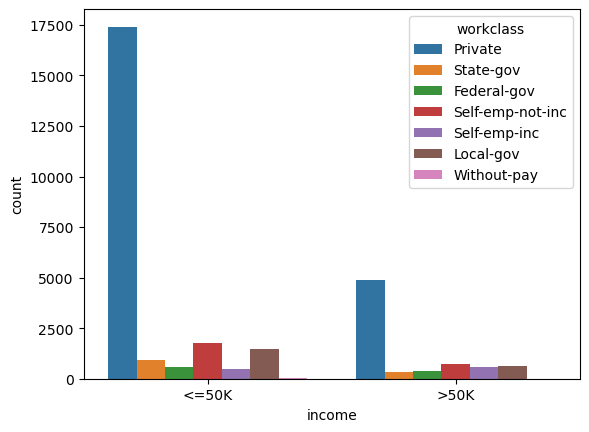

In [38]:
sns.countplot(data=data_preprocessed, x="income", hue="workclass")
plt.show()

In [39]:
pd.crosstab(data_preprocessed["workclass"], data_preprocessed["income"])

income,<=50K,>50K
workclass,,
Federal-gov,578,365
Local-gov,1458,609
Private,17410,4876
Self-emp-inc,474,600
Self-emp-not-inc,1785,714
State-gov,935,344
Without-pay,14,0


In [40]:
pd.crosstab(data_preprocessed["workclass"], data_preprocessed["income"], normalize="index")

income,<=50K,>50K
workclass,,
Federal-gov,0.612937,0.387063
Local-gov,0.705370,0.294630
Private,0.781208,0.218792
Self-emp-inc,0.441341,0.558659
Self-emp-not-inc,0.714286,0.285714
State-gov,0.731040,0.268960
Without-pay,1.000000,0.000000


In [41]:
data_preprocessed["workclass"].value_counts()

workclass
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64

In [42]:
data_preprocessed["workclass"].value_counts(normalize=True) * 100

workclass
Private             73.887673
Self-emp-not-inc     8.285260
Local-gov            6.852994
State-gov            4.240435
Self-emp-inc         3.560772
Federal-gov          3.126451
Without-pay          0.046416
Name: proportion, dtype: float64

There are 7 classes, and they are imbalanced, with `Private` being dominant at ~74% of the data. The in-class distribution with `income` is roughly similar across most classes: around ~2:3 earn `<=50K` and ~1:3 earn `>50K`, except for `Self-emp-inc` and `Federal-gov`, which show a moderately different trend. The `Self-emp-inc` group, in particular, has the highest concentration of `>50K` earners. Although it constitutes only ~3.5% of the data, it displays distinct characteristics that are worth preserving.
Thus, the general trend in the data will be exploited by combining the classes into three distinct groups: `Private`, `Public`, and `Self-employed`, to simplify the data, help alleviate class disparity, and maintain general semantic consistency and familiarity across the classes. 

In [44]:
data_preprocessed["workclass"] = data_preprocessed["workclass"].replace(
    ["Self-emp-not-inc","Local-gov","State-gov","Federal-gov","Without-pay"], "Public"
)
data_preprocessed["workclass"] = data_preprocessed["workclass"].replace(
    ["Self-emp-inc"], "Self-employed"
)

In [45]:
data_preprocessed["workclass"].value_counts()

workclass
Private          22286
Public            6802
Self-employed     1074
Name: count, dtype: int64

---
Now lets explore `education`.

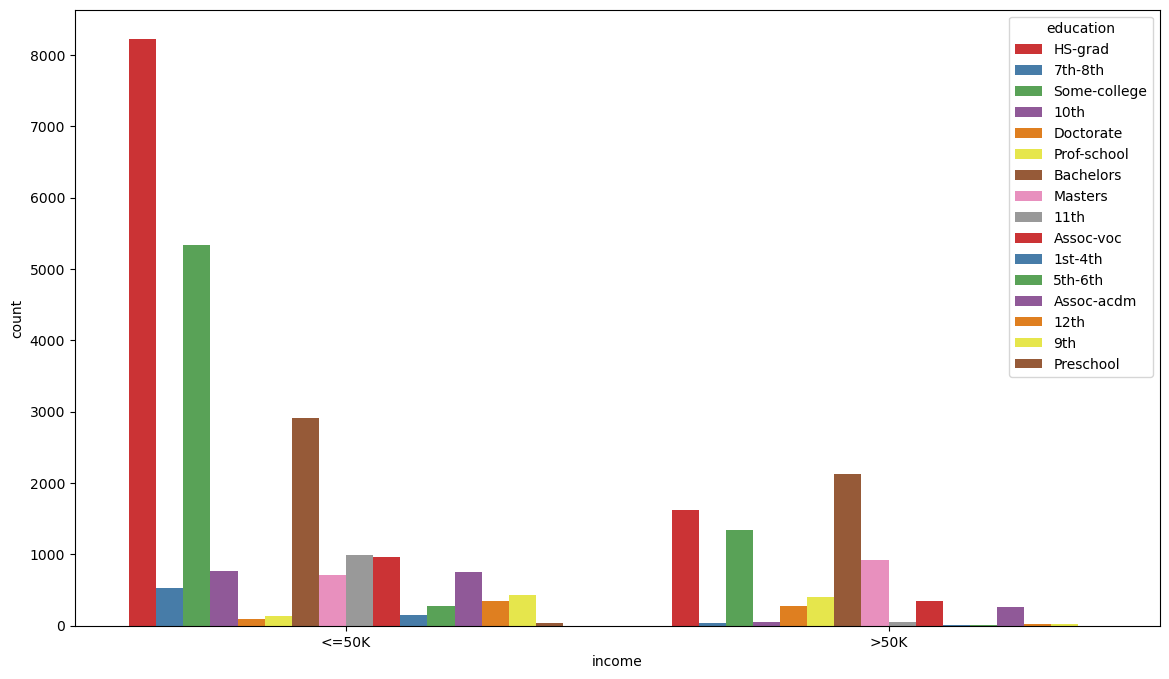

In [47]:
plt.figure(figsize=(14, 8))
sns.countplot(data=data_preprocessed, x="income", hue="education",palette="Set1")
plt.show()

In [48]:
pd.crosstab(data_preprocessed["education"], data_preprocessed["income"])

income,<=50K,>50K
education,,
10th,761,59
11th,989,59
12th,348,29
1st-4th,145,6
5th-6th,276,12
7th-8th,522,35
9th,430,25
Assoc-acdm,752,256
Assoc-voc,963,344


In [49]:
pd.crosstab(data_preprocessed["education"], data_preprocessed["income"], normalize="index") * 100

income,<=50K,>50K
education,,
10th,92.804878,7.195122
11th,94.370229,5.629771
12th,92.307692,7.692308
1st-4th,96.026490,3.973510
5th-6th,95.833333,4.166667
7th-8th,93.716338,6.283662
9th,94.505495,5.494505
Assoc-acdm,74.603175,25.396825
Assoc-voc,73.680184,26.319816


In [50]:
data_preprocessed["education"].value_counts(normalize=True) * 100

education
HS-grad         32.623831
Some-college    22.140442
Bachelors       16.723029
Masters          5.394205
Assoc-voc        4.333267
11th             3.474571
Assoc-acdm       3.341953
10th             2.718653
7th-8th          1.846695
Prof-school      1.796963
9th              1.508521
12th             1.249917
Doctorate        1.243286
5th-6th          0.954844
1st-4th          0.500630
Preschool        0.149194
Name: proportion, dtype: float64

There are 16 imbalanced classes; the dominant class is `HS-grad`, followed by `Some-college` and `Bachelors`. The remaining classes are sparse and spread thin. All those who didn’t finish high school have similar in-class income distributions. Those who have associate degrees, academic, or vocational education show similar income patterns. Individuals who completed some college education improved their income slightly compared to high school graduates, yet they earn less than those with associate degrees. In this order: `Bachelors`, `Masters`, `Doctorate`, and `Prof-school` income distributions increase, making them the best earners, especially those with professional school degrees.

Thus, the classes will be handled as follows:

- All those who did not finish high school will be combined into `Other`.
- `HS-grad` will be left untouched.
- `Assoc-voc`, `Assoc-acdm`, and `Some-college` will be combined into `Undergrad/Associate`. Although `Some-college` earns less and is a larger group, which might hurt the model’s generalization, this will be accepted to improve familiarity across the classes, as their nearest similar group consists of those with associate degrees.
- `Bachelors` and `Masters` will be combined into `Bachelors/Masters`. They are distinct classes and have different patterns of income distribution compared to other classes. This might affect the model’s generalization, but it will be accepted, as they cannot be combined with other classes, and `Masters` is too small to be left separate and doesn’t follow the broader trend of the data.
- `Doctorate` and `Prof-school` will be combined into `Prof-school/Doctorate`. Collectively, they comprise about 3% of the data, a small percentage, but they represent the highest earners, which may provide a useful signal to the model.

In [52]:
Other = ["Preschool","1st-4th","5th-6th","7th-8th","9th","10th","11th","12th"]
Undergrad_Associate = ["Assoc-voc","Assoc-acdm","Some-college"]
Bacheloars_Masters = ["Bachelors","Masters"]
Profschool_Doctorate = ["Prof-school","Doctorate"]

data_preprocessed["education"] = data_preprocessed["education"].replace(Other, "Other")
data_preprocessed["education"] = data_preprocessed["education"].replace(Undergrad_Associate, "Undergrad/Associate")
data_preprocessed["education"] = data_preprocessed["education"].replace(Bacheloars_Masters, "Bacheloars/Masters")
data_preprocessed["education"] = data_preprocessed["education"].replace(Profschool_Doctorate, "Prof-school/Doctorate")

In [53]:
data_preprocessed["education"].value_counts()

education
HS-grad                  9840
Undergrad/Associate      8993
Bacheloars/Masters       6671
Other                    3741
Prof-school/Doctorate     917
Name: count, dtype: int64

---

Next is `marital.status`.

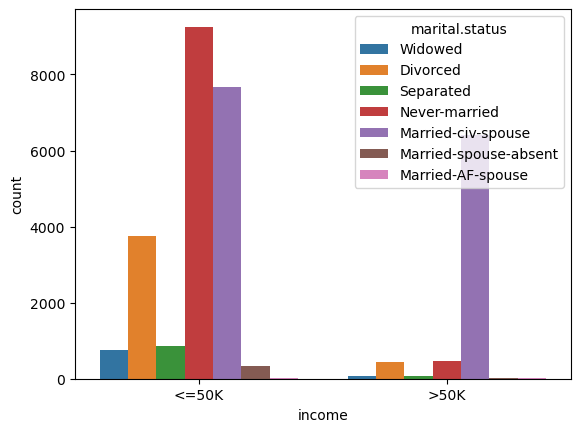

In [55]:
sns.countplot(data_preprocessed, x="income", hue="marital.status")
plt.show()

In [56]:
pd.crosstab(data_preprocessed["marital.status"], data_preprocessed["income"])

income,<=50K,>50K
marital.status,,
Divorced,3762,452
Married-AF-spouse,11,10
Married-civ-spouse,7666,6399
Married-spouse-absent,339,31
Never-married,9256,470
Separated,873,66
Widowed,747,80


In [57]:
pd.crosstab(data_preprocessed["marital.status"], data_preprocessed["income"], normalize="index") * 100

income,<=50K,>50K
marital.status,,
Divorced,89.273849,10.726151
Married-AF-spouse,52.380952,47.619048
Married-civ-spouse,54.504088,45.495912
Married-spouse-absent,91.621622,8.378378
Never-married,95.167592,4.832408
Separated,92.971246,7.028754
Widowed,90.326481,9.673519


In [58]:
data_preprocessed["marital.status"].value_counts(normalize=True) * 100

marital.status
Married-civ-spouse       46.631523
Never-married            32.245872
Divorced                 13.971222
Separated                 3.113189
Widowed                   2.741861
Married-spouse-absent     1.226709
Married-AF-spouse         0.069624
Name: proportion, dtype: float64

The dominant classes, in order, are `Married-civ-spouse`, `Never-married`, and `Divorced`, with the first two showing polarized patterns. The `Divorced` class shows a similar pattern to `Separated`, `Widowed`, and `Married-spouse-absent`, although the meaning of the latter is somewhat ambiguous. 

Based on semantics, pattern similarity, and simplicity:
- `Married-civ-spouse` and `Married-AF-spouse` will be combined into `Married`.
- `Divorced`, `Separated`, `Widowed`, and `Married-spouse-absent` will be combined into `Divorced/Widowed`, since based on this data, an absent spouse behaves statistically similar to divorced or widowed individuals rather than married ones. 
- `Never-married` will be left untouched.

In [60]:
data_preprocessed["marital.status"] = data_preprocessed["marital.status"].replace({
    "Married-civ-spouse": "Married",
    "Married-AF-spouse": "Married",
    "Married-spouse-absent": "Divorced/Widowed",
    "Divorced": "Divorced/Widowed",
    "Separated": "Divorced/Widowed",
    "Widowed": "Divorced/Widowed"
})


In [61]:
data_preprocessed["marital.status"].value_counts()

marital.status
Married             14086
Never-married        9726
Divorced/Widowed     6350
Name: count, dtype: int64

In [62]:
data_preprocessed.columns

Index(['age', 'workclass', 'education', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country', 'income'],
      dtype='object')

---

Next is `occupation`

In [64]:
data_preprocessed["occupation"].value_counts()

occupation
Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Priv-house-serv       143
Armed-Forces            9
Name: count, dtype: int64

In [65]:
data_preprocessed["occupation"].value_counts(normalize=True) * 100

occupation
Prof-specialty       13.387706
Craft-repair         13.361183
Exec-managerial      13.235197
Adm-clerical         12.336715
Sales                11.882501
Other-service        10.649161
Machine-op-inspct     6.518135
Transport-moving      5.211856
Handlers-cleaners     4.475831
Farming-fishing       3.278960
Tech-support          3.023672
Protective-serv       2.135137
Priv-house-serv       0.474106
Armed-Forces          0.029839
Name: proportion, dtype: float64

In [66]:
pd.crosstab(data_preprocessed["occupation"], data_preprocessed["income"])

income,<=50K,>50K
occupation,,
Adm-clerical,3223,498
Armed-Forces,8,1
Craft-repair,3122,908
Exec-managerial,2055,1937
Farming-fishing,874,115
Handlers-cleaners,1267,83
Machine-op-inspct,1721,245
Other-service,3080,132
Priv-house-serv,142,1


In [67]:
pd.crosstab(data_preprocessed["occupation"], data_preprocessed["income"], normalize="index") * 100

income,<=50K,>50K
occupation,,
Adm-clerical,86.616501,13.383499
Armed-Forces,88.888889,11.111111
Craft-repair,77.468983,22.531017
Exec-managerial,51.477956,48.522044
Farming-fishing,88.372093,11.627907
Handlers-cleaners,93.851852,6.148148
Machine-op-inspct,87.538149,12.461851
Other-service,95.890411,4.109589
Priv-house-serv,99.300699,0.699301


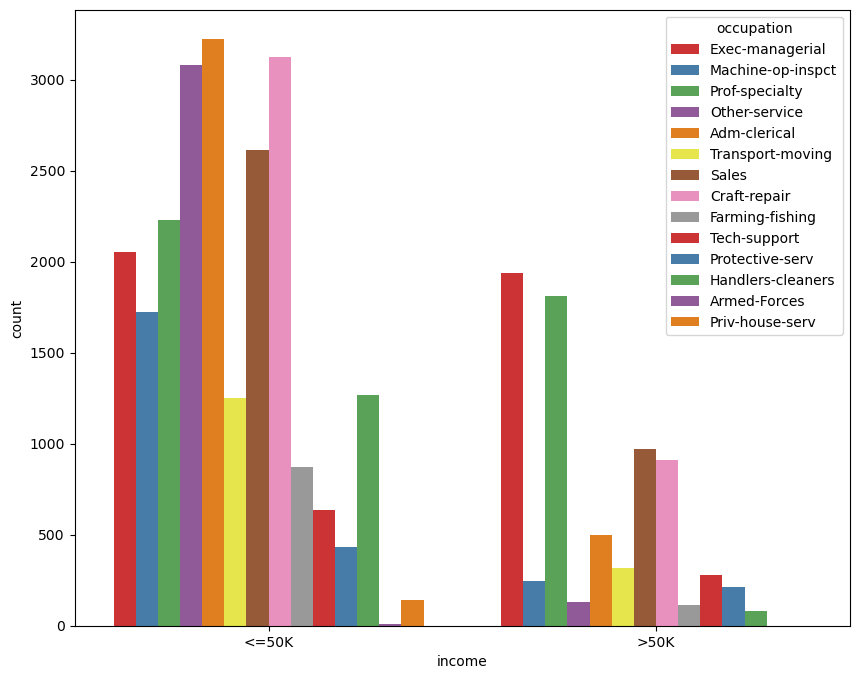

In [68]:
plt.figure(figsize=(10,8))
sns.countplot(data_preprocessed, x="income", hue="occupation", palette="Set1")
plt.show()

Occupation is generally correlated with income, and this is evident in this dataset. For example, `Exec-managerial` and `Prof-specialty` are the highest earners, which is consistent with real-world observations, especially given the context of other occupations in this dataset. Additionally, the samples are distributed across the different classes with no markedly dominant class relative to others.

Furthermore, each occupation is unique in its nature and semantics. There are no meaningful combinations that can be made, as merging based solely on data pattern similarity would produce arbitrary and unrelated groups. For instance, combining `Farming-fishing` and `Armed-Forces` into a single class such as `Farming-fishing/Armed-Forces` would be confusing. Although such an approach would considerably reduce the cardinality of this feature and might preserve the model’s predictive performance, it would likely do so only for this dataset’s training and testing phases. The generalizability would worsen, and interpretability would be markedly reduced.

For this reason, only `Armed-Forces` and `Priv-house-serv`, which together comprise approximately 0.5% of the data, will be combined with `Other-service`, as they share data pattern similarity and represent rare, non-meaningful standalone classes.

In [70]:
data_preprocessed["occupation"] = data_preprocessed["occupation"].replace({
    "Armed-Forces":"Other-service",
    "Priv-house-serv":"Other-service"
})

In [71]:
data_preprocessed["occupation"].value_counts()

occupation
Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3364
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Name: count, dtype: int64

---
Next is `relationship`.

In [73]:
data_preprocessed["relationship"].value_counts()

relationship
Husband           12463
Not-in-family      7726
Own-child          4466
Unmarried          3212
Wife               1406
Other-relative      889
Name: count, dtype: int64

In [74]:
pd.crosstab(data_preprocessed["relationship"], data_preprocessed["marital.status"])

marital.status,Divorced/Widowed,Married,Never-married
relationship,,,
Husband,0,12463,0
Not-in-family,3264,14,4448
Other-relative,222,119,548
Own-child,453,84,3929
Unmarried,2411,0,801
Wife,0,1406,0


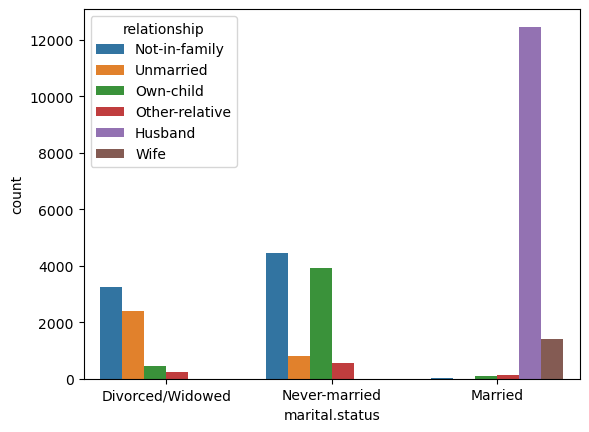

In [75]:
sns.countplot(data_preprocessed, x="marital.status", hue="relationship")
plt.show()

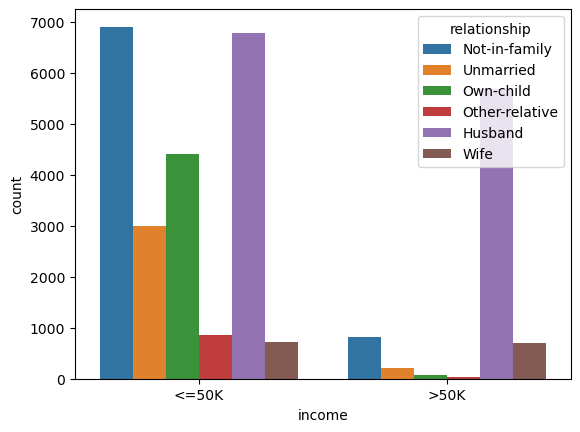

In [76]:
sns.countplot(data_preprocessed, x="income", hue="relationship")
plt.show()

This feature will be dropped, as its general meaning and data are redundant, and some of its classes show collinearity with `marital-status`. Moreover, marital status is a more general feature with clearer and more interpretable classes, while the categories of `relationship` can be ambiguous and broad. Additionally, this feature became distorted after the merging performed in marital-status.

In [78]:
data_preprocessed = data_preprocessed.drop(columns="relationship")

In [79]:
data_preprocessed.head()

,age,workclass,education,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,HS-grad,9,Divorced/Widowed,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
3,54,Private,Other,4,Divorced/Widowed,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Undergrad/Associate,10,Divorced/Widowed,Prof-specialty,White,Female,0,3900,40,United-States,<=50K
5,34,Private,HS-grad,9,Divorced/Widowed,Other-service,White,Female,0,3770,45,United-States,<=50K
6,38,Private,Other,6,Divorced/Widowed,Adm-clerical,White,Male,0,3770,40,United-States,<=50K


---
Next is `race`.

In [81]:
data_preprocessed["race"].value_counts()

race
White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: count, dtype: int64

In [82]:
data_preprocessed["race"].value_counts(normalize=True) * 100

race
White                 85.979046
Black                  9.339566
Asian-Pac-Islander     2.967310
Amer-Indian-Eskimo     0.948213
Other                  0.765864
Name: proportion, dtype: float64

In [83]:
pd.crosstab(data_preprocessed["race"], data_preprocessed["income"])

income,<=50K,>50K
race,,
Amer-Indian-Eskimo,252,34
Asian-Pac-Islander,647,248
Black,2451,366
Other,210,21
White,19094,6839


In [84]:
pd.crosstab(data_preprocessed["race"], data_preprocessed["income"], normalize="index") * 100

income,<=50K,>50K
race,,
Amer-Indian-Eskimo,88.111888,11.888112
Asian-Pac-Islander,72.290503,27.709497
Black,87.007455,12.992545
Other,90.909091,9.090909
White,73.628196,26.371804


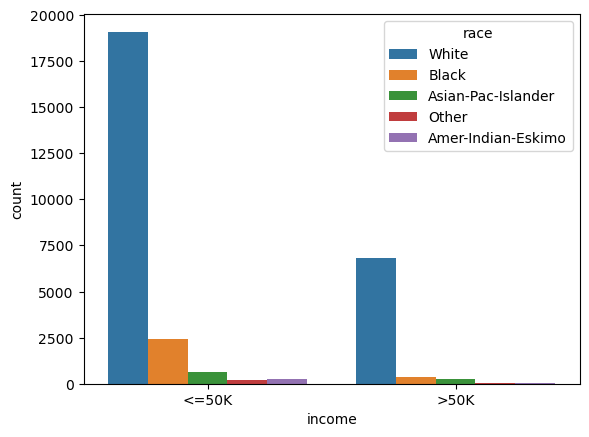

In [85]:
sns.countplot(data_preprocessed, x="income", hue="race")
plt.show()

Race will be simplified by combining the rare classes `Amer-Indian-Eskimo` and `Asian-Pac-Islander` into `Other`. These two are already have categories representing diverse subgroups, and merging them might increases the representativeness and robustness of the `Other` class. The `White` and `Black` classes will be left untouched, as they constitute the majority of the dataset and are distinct in both size and socioeconomic distribution.

In [87]:
data_preprocessed["race"] = data_preprocessed["race"].replace({"Amer-Indian-Eskimo":"Other","Asian-Pac-Islander":"Other"})

In [88]:
data_preprocessed["race"].value_counts()

race
White    25933
Black     2817
Other     1412
Name: count, dtype: int64

---

In [90]:
data_preprocessed["sex"].value_counts()

sex
Male      20380
Female     9782
Name: count, dtype: int64

Regarding `sex`, it will be left untouched, as it is already binary and well-defined.

---
Next is `native.country`.

In [93]:
data_preprocessed["native.country"].value_counts()

native.country
United-States                 27504
Mexico                          610
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
Italy                            68
China                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        63
Japan                            59
Poland                           56
Columbia                         56
Iran                             42
Taiwan                           42
Haiti                            42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
Ecuador      

In [94]:
data_preprocessed["native.country"].value_counts().size

41

In [95]:
data_preprocessed["native.country"].value_counts(normalize=True) * 100

native.country
United-States                 91.187587
Mexico                         2.022412
Philippines                    0.623301
Germany                        0.424375
Puerto-Rico                    0.361382
Canada                         0.354751
El-Salvador                    0.331543
India                          0.331543
Cuba                           0.305020
England                        0.285127
Jamaica                        0.265234
South                          0.235396
Italy                          0.225449
China                          0.225449
Dominican-Republic             0.222134
Vietnam                        0.212188
Guatemala                      0.208872
Japan                          0.195610
Poland                         0.185664
Columbia                       0.185664
Iran                           0.139248
Taiwan                         0.139248
Haiti                          0.139248
Portugal                       0.112725
Nicaragua                

In [96]:
pd.crosstab(data_preprocessed["native.country"], data_preprocessed["income"])

income,<=50K,>50K
native.country,,
Cambodia,11,7
Canada,71,36
China,48,20
Columbia,54,2
Cuba,67,25
Dominican-Republic,65,2
Ecuador,23,4
El-Salvador,91,9
England,56,30


In [97]:
pd.crosstab(data_preprocessed["native.country"], data_preprocessed["income"], normalize="index") * 100

income,<=50K,>50K
native.country,,
Cambodia,61.111111,38.888889
Canada,66.355140,33.644860
China,70.588235,29.411765
Columbia,96.428571,3.571429
Cuba,72.826087,27.173913
Dominican-Republic,97.014925,2.985075
Ecuador,85.185185,14.814815
El-Salvador,91.000000,9.000000
England,65.116279,34.883721


Approximately 91% of the data belongs to `United-States`, while the remaining ~9% is spread thinly across 40 other classes. Among them, 39 categories each represent less than ~0.8% of the data. This high sparsity makes the feature less meaningful for modeling and potentially introduces noise, especially given its high cardinality. Even if the feature carries some signal, the resulting model would likely be fragile and sensitive to slight shifts in the data. Also, combining these classes is not a valid option, as it would be difficult to establish meaningful relationships without introducing artificial patterns. Therefore, this feature will be removed.

In [99]:
data_preprocessed = data_preprocessed.drop(columns="native.country")

In [100]:
data_preprocessed.head()

,age,workclass,education,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,income
1,82,Private,HS-grad,9,Divorced/Widowed,Exec-managerial,White,Female,0,4356,18,<=50K
3,54,Private,Other,4,Divorced/Widowed,Machine-op-inspct,White,Female,0,3900,40,<=50K
4,41,Private,Undergrad/Associate,10,Divorced/Widowed,Prof-specialty,White,Female,0,3900,40,<=50K
5,34,Private,HS-grad,9,Divorced/Widowed,Other-service,White,Female,0,3770,45,<=50K
6,38,Private,Other,6,Divorced/Widowed,Adm-clerical,White,Male,0,3770,40,<=50K


---
Next are the numerical features.

In [102]:
data_preprocessed.corr(numeric_only=True)

,age,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,0.043526,0.080154,0.060165,0.101599
education.num,0.043526,1.000000,0.124416,0.079646,0.152522
capital.gain,0.080154,0.124416,1.000000,-0.032229,0.080432
capital.loss,0.060165,0.079646,-0.032229,1.000000,0.052417
hours.per.week,0.101599,0.152522,0.080432,0.052417,1.000000


In [103]:
data_preprocessed.describe()

,age,education.num,capital.gain,capital.loss,hours.per.week
count,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,10.121312,1092.007858,88.372489,40.931238
std,13.134665,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


First are `age` and `hours.per.week`.

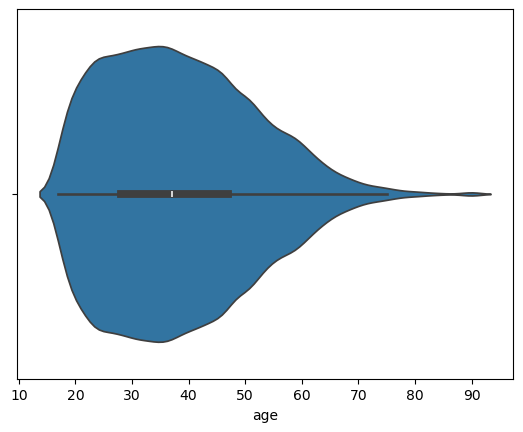

In [105]:
sns.violinplot(data_preprocessed, x="age")
plt.show()

In [106]:
data_preprocessed[data_preprocessed["age"] > 70].count()

age               384
workclass         384
education         384
education.num     384
marital.status    384
occupation        384
race              384
sex               384
capital.gain      384
capital.loss      384
hours.per.week    384
income            384
dtype: int64

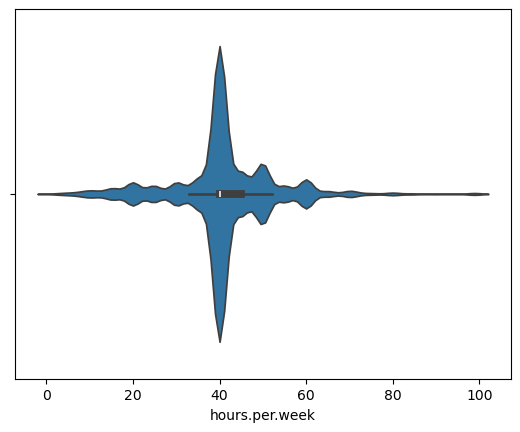

In [107]:
sns.violinplot(data_preprocessed, x="hours.per.week")
plt.show()

In [108]:
data_preprocessed[data_preprocessed["hours.per.week"] > 90].count()

age               103
workclass         103
education         103
education.num     103
marital.status    103
occupation        103
race              103
sex               103
capital.gain      103
capital.loss      103
hours.per.week    103
income            103
dtype: int64

Since they have rare outliers, they will be retained. They are unlikely to affect the stability of the model and may represent actual individuals. Therefore, removing or capping these values would likely have minimal impact on model performance.

Next is `education.num`. 

In [111]:
pd.crosstab(data_preprocessed["education.num"], data_preprocessed["education"])

education,Bacheloars/Masters,HS-grad,Other,Prof-school/Doctorate,Undergrad/Associate
education.num,,,,,
1,0,0,45,0,0
2,0,0,151,0,0
3,0,0,288,0,0
4,0,0,557,0,0
5,0,0,455,0,0
6,0,0,820,0,0
7,0,0,1048,0,0
8,0,0,377,0,0
9,0,9840,0,0,0


This feature will be dropped for the following reasons
- It does not provide unique information that the model can meaningfully utilize; its interpretation is limited to representing the numeric encoding of education levels.
- It is ambiguous in meaning and in distinction compared to `education`.
- It is redundant with the `education` feature, as both convey the same information.
-  It shows a hierarchical relationship with the classes of `education`, which may introduce collinearity into the model.

In [113]:
data_preprocessed = data_preprocessed.drop(columns="education.num")

In [114]:
data_preprocessed.head()

,age,workclass,education,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,income
1,82,Private,HS-grad,Divorced/Widowed,Exec-managerial,White,Female,0,4356,18,<=50K
3,54,Private,Other,Divorced/Widowed,Machine-op-inspct,White,Female,0,3900,40,<=50K
4,41,Private,Undergrad/Associate,Divorced/Widowed,Prof-specialty,White,Female,0,3900,40,<=50K
5,34,Private,HS-grad,Divorced/Widowed,Other-service,White,Female,0,3770,45,<=50K
6,38,Private,Other,Divorced/Widowed,Adm-clerical,White,Male,0,3770,40,<=50K


Now, `capital.gain` and `capital.loss`.

In [116]:
data_preprocessed[(data_preprocessed["capital.gain"] > 0)].value_counts().size

2512

In [117]:
data_preprocessed[(data_preprocessed["capital.loss"] > 0)].value_counts().size

1415

Although those who have any capital gain or loss are rare, a new feature will be created, named `Net_capital_gain`, which follows the formula:
$$
\text{Net capital gain} = \text{capital gain} - \text{capital loss}
$$
After that, more analysis will be done to assess its impact and predictive potential.

In [119]:
data_preprocessed = data_preprocessed.rename(columns={"capital.gain":"Net_Capital_Gain"})

In [120]:
data_preprocessed["Net_Capital_Gain"] = data_preprocessed["Net_Capital_Gain"] - data_preprocessed["capital.loss"]

In [121]:
data_preprocessed = data_preprocessed.drop(columns="capital.loss")

In [122]:
data_preprocessed.groupby('income')['Net_Capital_Gain'].describe()

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,22654.0,95.445837,994.492331,-4356.0,0.0,0.0,0.0,41310.0
>50K,7508.0,3743.929142,14451.166890,-3683.0,0.0,0.0,0.0,99999.0


In [123]:
data_preprocessed[(data_preprocessed["Net_Capital_Gain"] > 90000)].value_counts().size

146

Although individuals with capital gains and losses are rare, these two concepts are indicators of income. This new feature shows a predictive signal, as those with higher net capital gains are more likely to have an income >50K.

In [125]:
data_preprocessed.head()

,age,workclass,education,marital.status,occupation,race,sex,Net_Capital_Gain,hours.per.week,income
1,82,Private,HS-grad,Divorced/Widowed,Exec-managerial,White,Female,-4356,18,<=50K
3,54,Private,Other,Divorced/Widowed,Machine-op-inspct,White,Female,-3900,40,<=50K
4,41,Private,Undergrad/Associate,Divorced/Widowed,Prof-specialty,White,Female,-3900,40,<=50K
5,34,Private,HS-grad,Divorced/Widowed,Other-service,White,Female,-3770,45,<=50K
6,38,Private,Other,Divorced/Widowed,Adm-clerical,White,Male,-3770,40,<=50K


Now, the features will be one-hot encoded.

In [127]:
columns = data_preprocessed.select_dtypes(include="object").columns

In [128]:
for col in columns:
    print(data_preprocessed[col].value_counts())

workclass
Private          22286
Public            6802
Self-employed     1074
Name: count, dtype: int64
education
HS-grad                  9840
Undergrad/Associate      8993
Bacheloars/Masters       6671
Other                    3741
Prof-school/Doctorate     917
Name: count, dtype: int64
marital.status
Married             14086
Never-married        9726
Divorced/Widowed     6350
Name: count, dtype: int64
occupation
Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3364
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Name: count, dtype: int64
race
White    25933
Black     2817
Other     1412
Name: count, dtype: int64
sex
Male      20380
Female     9782
Name: count, dtype: int64
income
<=50K    22654
>50K      7508
Name: count, dtype: int64


In [129]:
data_preprocessed = pd.get_dummies(data_preprocessed, columns=["sex","income"], drop_first=True, dtype="float32")

In [130]:
data_preprocessed = pd.get_dummies(data_preprocessed, columns=["workclass","education","marital.status","occupation","race"], dtype="float32")

In [131]:
data_preprocessed.shape

(30162, 31)

In [132]:
data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 1 to 32560
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              30162 non-null  int64  
 1   Net_Capital_Gain                 30162 non-null  int64  
 2   hours.per.week                   30162 non-null  int64  
 3   sex_Male                         30162 non-null  float32
 4   income_>50K                      30162 non-null  float32
 5   workclass_Private                30162 non-null  float32
 6   workclass_Public                 30162 non-null  float32
 7   workclass_Self-employed          30162 non-null  float32
 8   education_Bacheloars/Masters     30162 non-null  float32
 9   education_HS-grad                30162 non-null  float32
 10  education_Other                  30162 non-null  float32
 11  education_Prof-school/Doctorate  30162 non-null  float32
 12  education_Undergrad/Ass

##### **2.3.2 - Feature Engineering (data_full_encoding and data_robust)**

For data_full_encoding and data_robust, the columns `relationship`, `education.num`, and `native.country` will be retained to test how the original features perform compared to the engineered version in data_preprocessed. One-hot encoding will be applied to all categorical features in data_full_encoding.

In [135]:
categorical_columns = data_full_encoding.select_dtypes(include="object").columns
categorical_columns = categorical_columns.drop(["sex","income"])

In [136]:
data_full_encoding = pd.get_dummies(data_full_encoding, columns=categorical_columns, drop_first=False, dtype="float32")

In [137]:
data_full_encoding = pd.get_dummies(data_full_encoding, columns=["sex","income"], drop_first=True, dtype="float32")

In [138]:
data_full_encoding.shape

(30162, 103)

In [139]:
data_full_encoding.select_dtypes(include="int64")

,age,education.num,capital.gain,capital.loss,hours.per.week
1,82,9,0,4356,18
3,54,4,0,3900,40
4,41,10,0,3900,40
5,34,9,0,3770,45
6,38,6,0,3770,40
...,...,...,...,...,...
32556,22,10,0,0,40
32557,27,12,0,0,38
32558,40,9,0,0,40
32559,58,9,0,0,40


In [140]:
data_robust = pd.get_dummies(data_robust, columns=["income"], drop_first=True)

### **3 - Model Tranining and Evaluaion**

Two functions will be built: one to split the data, and the other for training and evaluation.

In [143]:
#Takes the dataset and split it into a tranining and testing sets
def split_data(dataset, target):
    """
    Split the dataset into training and testing sets.
    
    Parameters:
    - dataset: The speicific dataset that needs spliting
    - target: The target label

    
    Returns:
    - X_train, X_test, Y_train, Y_test: Sets which will be used to train and test the models
    """

    
    X = dataset.drop(target, axis=1)
    Y = dataset[target]
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, stratify=Y, random_state=1
    )
    
    return X_train, X_test, Y_train, Y_test

In [144]:
def train_and_evaluate(X_train, X_test, Y_train, Y_test, model, dataset_type, scaling=True):
    """
    Trains and evaluates a model on given data.
    
    Parameters:
    - X_train, X_test, Y_train, Y_test: Tranining and testing sets
    - model: Any estimator that supports fit and predict methods
    - data_type: String to indicate dataset type (preprocessed, fully one-hot endoded, or raw)
    - scaling: Boolean, whether to scale features
    
    """
    
    # Scale only numerical (int64) columns if scaling is True
    if scaling:
        scaler = StandardScaler()

        num_cols = X_train.select_dtypes(include="int64").columns
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_test[num_cols] = scaler.transform(X_test[num_cols])

    # Fit the model and calculate the time required for training
    start_train_time = time.time()
    model.fit(X_train, Y_train)
    end_train_time = time.time()
    elapsed_train_time = end_train_time - start_train_time

    
    # Make predictions and end calculate the time required for inference
    start_inference_time = time.time()
    prediction = model.predict(X_test)
    end_inference_time = time.time()
    elapsed_inference_time = end_inference_time - start_inference_time
    
    # Print evaluation metrics
    print(f"--- {dataset_type} ---")
    print(f"Accuracy: {round(accuracy_score(Y_test, prediction), 3)}")
    print(f"Precision: {round(precision_score(Y_test, prediction), 3)}")
    print(f"Recall: {round(recall_score(Y_test, prediction), 3)}")
    print(f"F1-score: {round(f1_score(Y_test, prediction), 3)}")
    print(f"Training time: {elapsed_train_time:.3f} seconds")
    print(f"Inference time: {elapsed_inference_time:.3f} seconds")



Three models will be defined:

- `model_preprocessed`: a logistic regression model that will use `data_preprocessed` for training and evaluation.
- `model_full_encoding`: a logistic regression model that will use `data_full_encoding` for training and evaluation.
- `model_robust`: a CatBoost model that will use `data_robust` for training and evaluation.


In [146]:
model_preprocessed = LogisticRegression(max_iter=1000)

In [147]:
model_full_encoding = LogisticRegression(max_iter=1000)

In [148]:
cat_columns = data_robust.select_dtypes(include="object").columns.tolist()

In [149]:
model_robust = CatBoostClassifier(silent=True, cat_features=cat_columns )

The the three datasets will be split.

In [151]:
X_train1, X_test1, Y_train1, Y_test1 = split_data(data_preprocessed, "income_>50K")

In [152]:
X_train2, X_test2, Y_train2, Y_test2 = split_data(data_full_encoding, "income_>50K")

In [153]:
X_train3, X_test3, Y_train3, Y_test3 = split_data(data_robust, "income_>50K")

Now, the three models will be trained and evaluated.

In [155]:
train_and_evaluate(X_train1, X_test1, Y_train1, Y_test1, model_preprocessed, "Featured-Engineered Dataset", scaling=True)

train_and_evaluate(X_train2, X_test2, Y_train2, Y_test2, model_full_encoding, "Fully One-Hot Encoded Dataset", scaling=True)

train_and_evaluate(X_train3, X_test3, Y_train3, Y_test3, model_robust, "Raw Dataset", scaling=False)

--- Featured-Engineered Dataset ---
Accuracy: 0.837
Precision: 0.716
Recall: 0.573
F1-score: 0.636
Training time: 0.025 seconds
Inference time: 0.000 seconds
--- Fully One-Hot Encoded Dataset ---
Accuracy: 0.846
Precision: 0.726
Recall: 0.61
F1-score: 0.663
Training time: 0.434 seconds
Inference time: 0.008 seconds
--- Raw Dataset ---
Accuracy: 0.871
Precision: 0.777
Recall: 0.674
F1-score: 0.722
Training time: 44.144 seconds
Inference time: 0.026 seconds


### **4 - Discussion and Conclusion**

The feature-engineered dataset achived a predictive performance of ~F1-score: 0.636 with only 30 features, demonstrating that reducing cardinality and simplifying categorical features can retain meaningful predictive power when done carefully, while improving interpretability and computational efficiency. This approach represents a balance between performance and explainability, which might make it more suitable for scenarios where model transparency and maintainability are prioritized.

The fully one-hot encoded dataset achieved an F1-score of ~0.663 with 103 features. It performed slightly better, but at the cost of higher model complexity, with ~70% more features compared to the feature-engineered model.

The raw dataset achieved the highest F1-score of 0.722. However, it required substantially more training time (over 1200 times longer than the feature-engineered model).

The choice depends on the context and intended usage:

- If interpretability, simplicity, and fast inference are key, the feature-engineered dataset might offers an optimal trade-off.

- If maximum accuracy and predictive power are the primary goals, computation and inference times are acceptable, and the increased integraion complexity is manageable, then the CatBoost model may be the preferred choice.


In conclusion, this notebook shows the trade-offs between feature complexity, performance, and practicality. Feature engineering produced a compact, interpretable model with competitive accuracy. Full one-hot encoding improved performance slightly but with increased dimensionality, complexity and perhaps fragility. The raw dataset with CatBoost achieved the highest predictive power but required the most resources and might pose the highest techinical complexity.

